In [9]:
#importing the required packages
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy,AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import itertools
import cv2
import scipy.integrate as integrate
import scipy
from tensorflow.keras.applications import VGG16,VGG19,ResNet50,ResNet101, ResNet152,InceptionResNetV2,inception_v3

## Importing Images

In [4]:
data_dir = "D:\AI_Projects\TB\Dataset"
categories = ["Normal", "Tuberculosis"]

In [7]:
#resizing images
img_size = (256, 256)  
data = []

In [8]:
for category_id, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, img_size)
        data.append([img_array, category_id])

data = shuffle(data)

In [16]:
X = np.array([x[0] for x in data]).reshape(-1, img_size[0], img_size[1], 1)
y = np.array([x[1] for x in data])

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

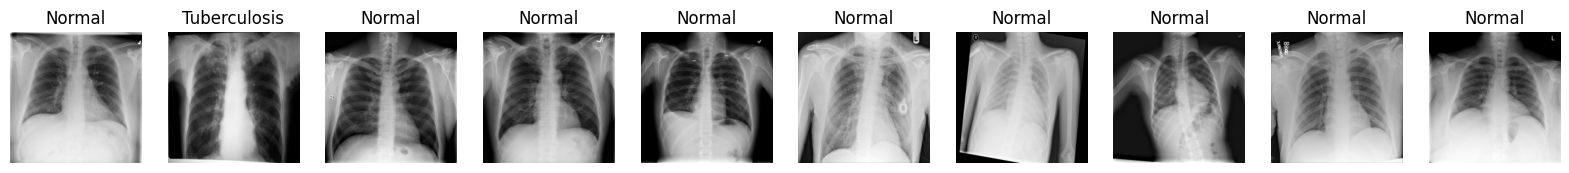

In [12]:
def plot_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(img_size), cmap='gray')
        axes[i].set_title(categories[labels[i]])
        axes[i].axis('off')
    plt.show()
    
plot_images(X_train, y_train)

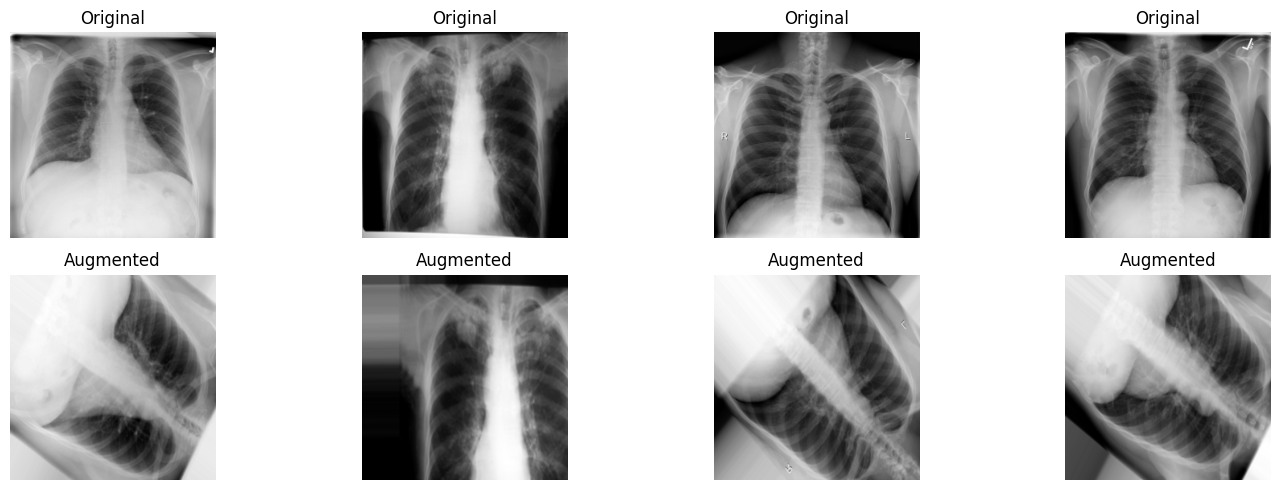

In [23]:
datagen = ImageDataGenerator(
    rotation_range=60,  # Random rotation in the range of 0-60 degrees
    width_shift_range=0.2,  # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=True,  # Random vertical flipping
    fill_mode='nearest'  
)

datagen.fit(X_train)

def plot_original_and_augmented(original_images, augmented_images, labels, num_images=4):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        axes[0, i].imshow(original_images[i].reshape(img_size), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(augmented_images[i].reshape(img_size), cmap='gray')
        axes[1, i].set_title("Augmented")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


batch_size = 4  
num_augmented = 2  

augmented_generator = datagen.flow(X_train[:batch_size], y_train[:batch_size], batch_size=batch_size)

augmented_images, _ = next(augmented_generator)

plot_original_and_augmented(X_train[:batch_size], augmented_images, [y_train[0]] * batch_size)



In [24]:
num_train_samples = X_train.shape[0]
num_val_samples = X_val.shape[0]
num_test_samples = X_test.shape[0]

print("Number of samples in training set:", num_train_samples)
print("Number of samples in validation set:", num_val_samples)
print("Number of samples in testing set:", num_test_samples)

num_normal_samples = np.sum(y_train == 0) + np.sum(y_val == 0) + np.sum(y_test == 0)
num_infected_samples = np.sum(y_train == 1) + np.sum(y_val == 1) + np.sum(y_test == 1)

print("Number of TB_normal samples:", num_normal_samples)
print("Number of TB_infected samples:", num_infected_samples)


Number of samples in training set: 2688
Number of samples in validation set: 672
Number of samples in testing set: 840
Number of TB_normal samples: 3500
Number of TB_infected samples: 700


In [25]:
def count_samples_per_class(y):
    num_classes = np.max(y) + 1
    class_counts = np.zeros(num_classes, dtype=int)
    for i in range(num_classes):
        class_counts[i] = np.sum(y == i)
    return class_counts

train_class_counts = count_samples_per_class(y_train)
print("Number of samples per class in training set:")
for i, count in enumerate(train_class_counts):
    print(f"Class {i}: {count}")

val_class_counts = count_samples_per_class(y_val)
print("\nNumber of samples per class in validation set:")
for i, count in enumerate(val_class_counts):
    print(f"Class {i}: {count}")

test_class_counts = count_samples_per_class(y_test)
print("\nNumber of samples per class in testing set:")
for i, count in enumerate(test_class_counts):
    print(f"Class {i}: {count}")

Number of samples per class in training set:
Class 0: 2223
Class 1: 465

Number of samples per class in validation set:
Class 0: 571
Class 1: 101

Number of samples per class in testing set:
Class 0: 706
Class 1: 134
